#                      Real-Time Location System Case Study

##                          Lei Jiang, Kristen Rollins, Daniel Davieau

### requirement:
Include an introduction to explain the case study, explain the approach used to complete the case study and explain the output achieved.  Explanations of output should be included as close to the output or figures as possible.

List all references used, including the book by Nolan and Lang.


### write abstract, intro, ...
t="Timestamp" 

__id="MACofScanDevice"__ A unique ID of a network device.  The ﬁrst of these 3 sets of pairs of digits, i.e., mm:mm:mm, identiﬁes the manufacturer of the equipment. The second set of 3 pairs (the ss) identiﬁes the particular piece of equipment, both the model and the unique d
evice. 

__pos="RealPosition"__ the physical coordinate of the scanning device 

__degree="orientation"__ the orientation of the user carrying the scanning device in degrees

__MACofResponse1="SignalStrengthValue,Frequency,Mode"__ MACaddressofarespondingpeer(e.g.,anaccesspointoradevice in adhoc mode) with the corresponding values for signal strength in dBm (Decibel-milliwatts), the channel frequency and its mode (access point = 3, device in adhoc mode = 1)

__MACofResponseN="SignalStrengthValue,Frequency,Mode"__ "..."

__See formula on Question 12 for weighting for final question.__

### rephrase the questions
#### Conduct a more thorough data analysis into these two MAC addresses including determining locations by using data corresponding to both MAC addresses.  Which of these two MAC addresses should be used and which should not be used for RTLS? Which MAC address yields the best prediction of location?  Does using data for both MAC addresses simultaneously yield more, or less, accurate prediction of location? (Note: this portion is derived from Exercise Q.9 in Nolan and Lang.)


#### weighted kNN




In [1]:
setwd("C:/Users/N1110/Desktop/QTW")
options(digits = 2)
# read in the entire file into a variable txt
# each line will be its own element
# txt = readLines("offline.final.trace.txt")

In [6]:
processLine = function(x)
{
  tokens = strsplit(x, "[;=,]")[[1]]
if (length(tokens) == 10)
  return(NULL)
tmp = matrix(tokens[ - (1:10) ], , 4, byrow = TRUE)
cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow(tmp), 6,
byrow = TRUE), tmp)
}


# create a function that will round off to the nearest major angle
roundOrientation = function(angles) {
  refs = seq(0, by = 45, length  = 9)
  q = sapply(angles, function(o) which.min(abs(o - refs)))
  c(refs[1:8], 0)[q]
}



In [4]:
# re do our data read combining all the anlysis we did here there are 7 SEVEN macids
readData = 
  function(filename = 'offline.final.trace.txt', 
           subMacs = c("00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd", "00:14:bf:b1:97:8a",
                       "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d",
                       "00:14:bf:b1:97:81"))
  {
    txt = readLines(filename)
    lines = txt[ substr(txt, 1, 1) != "#" ]
    tmp = lapply(lines, processLine)
    offline = as.data.frame(do.call("rbind", tmp), 
                            stringsAsFactors= FALSE) 
    
    names(offline) = c("time", "scanMac", 
                       "posX", "posY", "posZ", "orientation", 
                       "mac", "signal", "channel", "type")
    
     # keep only signals from access points
    offline = offline[ offline$type == "3", ]
    
    # drop scanMac, posZ, channel, and type - no info in them
    dropVars = c("scanMac", "posZ", "channel", "type")
    offline = offline[ , !( names(offline) %in% dropVars ) ]
    
    # drop more unwanted access points
    offline = offline[ offline$mac %in% subMacs, ]
    
    # convert numeric values
    numVars = c("time", "posX", "posY", "orientation", "signal")
    offline[ numVars ] = lapply(offline[ numVars ], as.numeric)

    # convert time to POSIX
    offline$rawTime = offline$time
    offline$time = offline$time/1000
    class(offline$time) = c("POSIXt", "POSIXct")
    
    # round orientations to nearest 45
    offline$angle = roundOrientation(offline$orientation)
      
    return(offline)
  }

In [62]:
offline = readData()

In [63]:
head(offline)

time                posX posY orientation mac               signal rawTime
1 2006-02-10 23:31:58 0    0    0           00:14:bf:b1:97:8a -38    1.1e+12
2 2006-02-10 23:31:58 0    0    0           00:14:bf:b1:97:90 -56    1.1e+12
3 2006-02-10 23:31:58 0    0    0           00:0f:a3:39:e1:c0 -53    1.1e+12
4 2006-02-10 23:31:58 0    0    0           00:14:bf:b1:97:8d -65    1.1e+12
5 2006-02-10 23:31:58 0    0    0           00:14:bf:b1:97:81 -65    1.1e+12
6 2006-02-10 23:31:58 0    0    0           00:14:bf:3b:c7:c6 -66    1.1e+12
  angle
1 0    
2 0    
3 0    
4 0    
5 0    
6 0

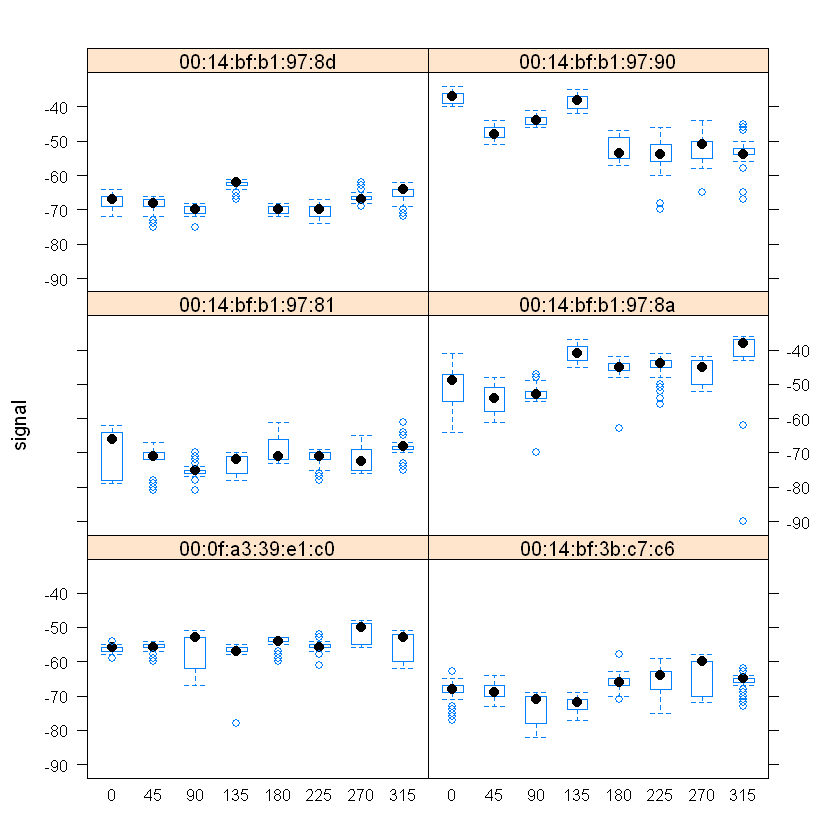

In [9]:
# plot signal strength for each device
# poor mac id 7.  he gets dropped
library(lattice)
bwplot(signal ~ factor(angle) | mac, data = offline, 
       subset = posX == 2 & posY == 12 
                & mac != "00:0f:a3:39:dd:cd", 
       layout = c(2,3))

In [10]:
# examine signal strength overall
summary(offline$signal)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    -98     -67     -59     -60     -53     -25 

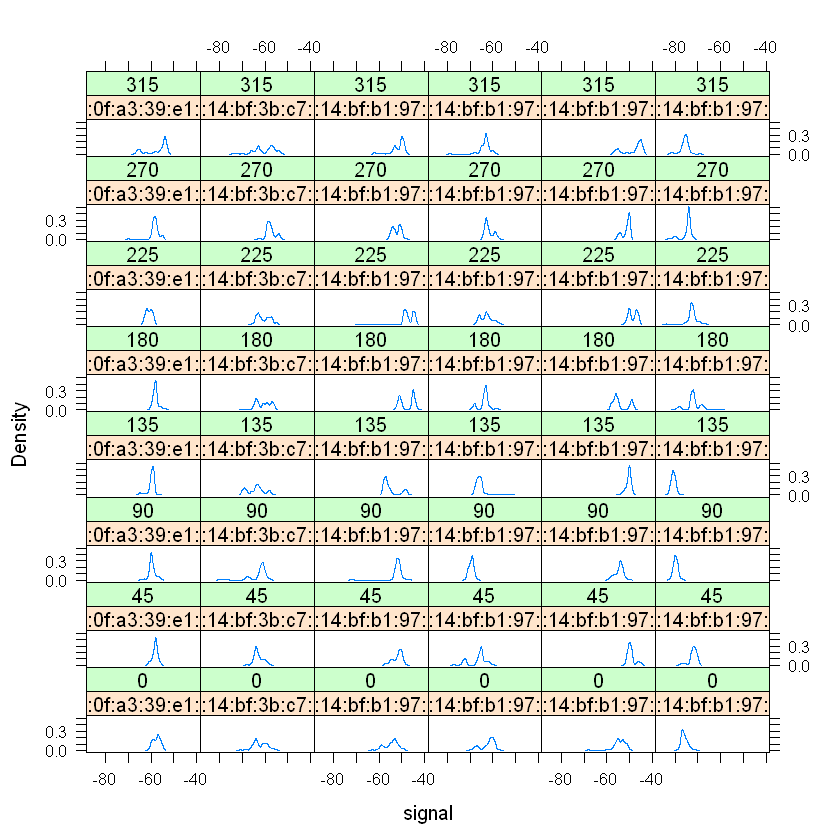

In [11]:
# density plots for SIX of the seven mac ids at X=24, Y=4
densityplot( ~ signal | mac + factor(angle), data = offline,
             subset = posX == 24 & posY == 4 & 
                         mac != "00:0f:a3:39:dd:cd",
             bw = 0.5, plot.points = FALSE)

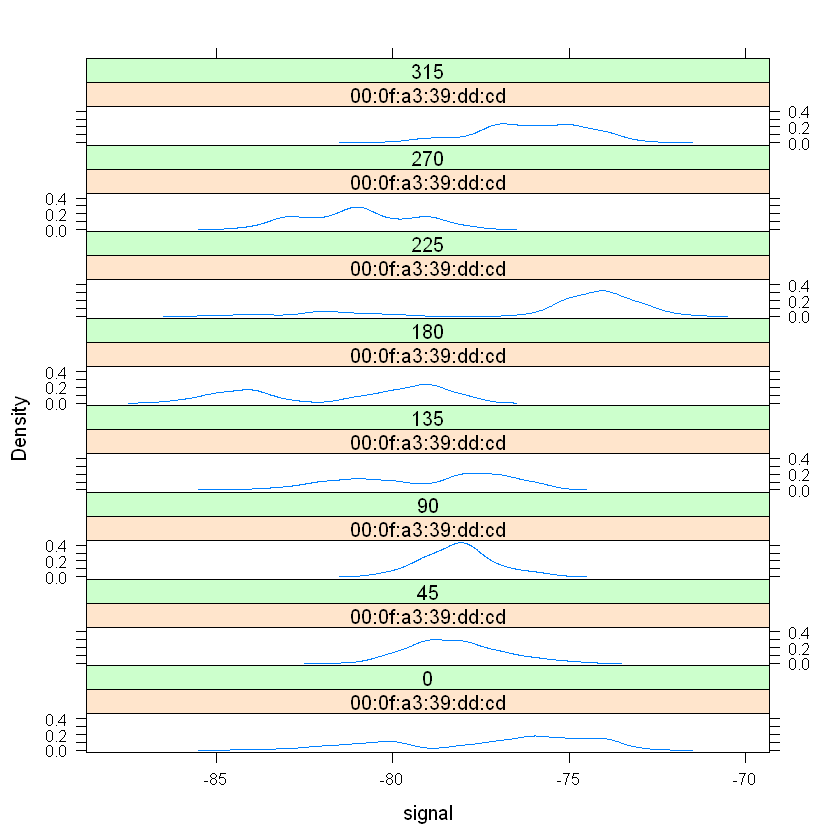

In [12]:
# density plots for the seventh mac ids at X=24, Y=4
# he was lonely
densityplot( ~ signal | mac + factor(angle), data = offline,
             subset = posX == 24 & posY == 4 & 
                         mac == "00:0f:a3:39:dd:cd",
             bw = 0.5, plot.points = FALSE)

In [64]:
#Setup all the data using the data summary
offline$posXY = paste(offline$posX, offline$posY, sep = "-")

byLocAngleAP = with(offline, 
                    by(offline, list(posXY, angle, mac), 
                       function(x) x))

signalSummary = 
  lapply(byLocAngleAP,            
         function(oneLoc) {
           ans = oneLoc[1, ]
           ans$medSignal = median(oneLoc$signal)
           ans$avgSignal = mean(oneLoc$signal)
           ans$num = length(oneLoc$signal)
           ans$sdSignal = sd(oneLoc$signal)
           ans$iqrSignal = IQR(oneLoc$signal)
           ans
           })

offlineSummary = do.call("rbind", signalSummary)  

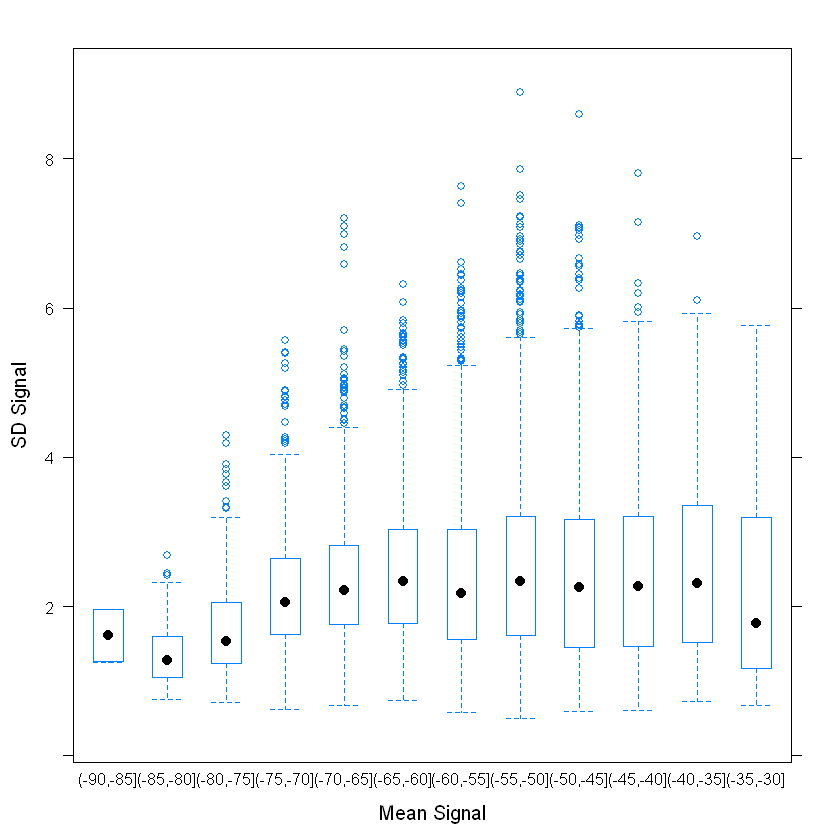

In [14]:
# look at the distribution of signal strength
breaks = seq(-90, -30, by = 5)
bwplot(sdSignal ~ cut(avgSignal, breaks = breaks),
       data = offlineSummary, 
       subset = mac != "00:0f:a3:39:dd:cd",
       xlab = "Mean Signal", ylab = "SD Signal")

In [65]:
subMacs = c("00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd", "00:14:bf:b1:97:8a",
                       "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d",
                       "00:14:bf:b1:97:81")

In [67]:
# here is where we drop a macid
offlineSummary0 = subset(offlineSummary, mac != subMacs[2])
offlineSummary1 = subset(offlineSummary, mac != subMacs[1])


x    y   
00:0f:a3:39:e1:c0  7.5  6.3
00:14:bf:b1:97:8a  2.5 -0.8
00:14:bf:3b:c7:c6 12.8 -2.8
00:14:bf:b1:97:90  1.0 14.0
00:14:bf:b1:97:8d 33.5  9.3
00:14:bf:b1:97:81 33.5  2.8

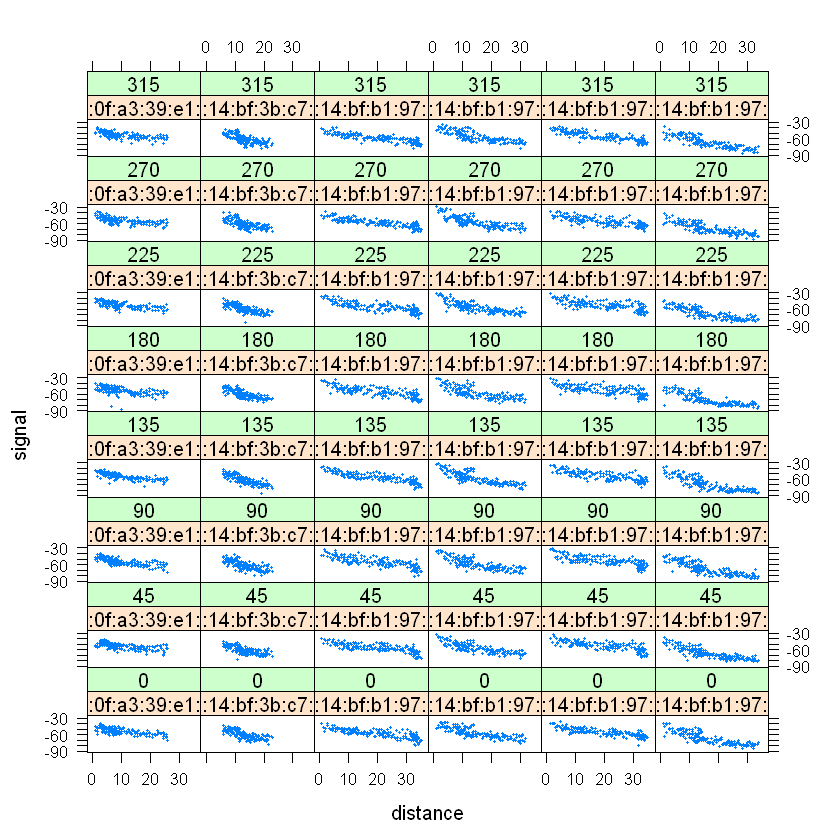

In [21]:
# Look at the access points
# signal strength vs distance

AP = matrix( c( 7.5, 6.3, 2.5, -.8, 12.8, -2.8,  
                1, 14, 33.5, 9.3,  33.5, 2.8),
            ncol = 2, byrow = TRUE,
            dimnames = list(subMacs[ -2 ], c("x", "y") ))

AP

diffs = offlineSummary[ , c("posX", "posY")] - 
          AP[ offlineSummary$mac, ]

offlineSummary$dist = sqrt(diffs[ , 1]^2 + diffs[ , 2]^2) # Eclidean 

xyplot(signal ~ dist | factor(mac) + factor(angle), 
       data = offlineSummary, pch = 19, cex = 0.3,
       xlab ="distance")

### Signal strength vs Distance

#### We used Eclidean distance for the calculation. The plot above indicates that the signal strength is negative correlated with the distance. Therefore, the further the access point is, the weaker the signal is.

## Prepare the test data

In [18]:
# prepare the test data

# tally signal strength

macs = unique(offlineSummary$mac)
online = readData("online.final.trace.txt", subMacs = macs)

online$posXY = paste(online$posX, online$posY, sep = "-")

length(unique(online$posXY))

tabonlineXYA = table(online$posXY, online$angle)
tabonlineXYA[1:6, ]

keepVars = c("posXY", "posX","posY", "orientation", "angle")
byLoc = with(online, 
             by(online, list(posXY), 
                function(x) {
                  ans = x[1, keepVars]
                  avgSS = tapply(x$signal, x$mac, mean)
                  y = matrix(avgSS, nrow = 1, ncol = 6,
                        dimnames = list(ans$posXY, names(avgSS)))
                  cbind(ans, y)
                }))

onlineSummary = do.call("rbind", byLoc)  

[1] 60

            
               0  45  90 135 180 225 270 315
  0-0.05       0   0   0 593   0   0   0   0
  0.15-9.42    0   0 606   0   0   0   0   0
  0.31-11.09   0   0   0   0   0 573   0   0
  0.47-8.2   590   0   0   0   0   0   0   0
  0.78-10.94 586   0   0   0   0   0   0   0
  0.93-11.69   0   0   0   0 583   0   0   0

In [28]:
onlineSummary

posXY      posX  posY  orientation angle 00:0f:a3:39:e1:c0
0-0.05     0-0.05      0.00  0.05 130.5       135   -52              
0.15-9.42  0.15-9.42   0.15  9.42 112.3        90   -55              
0.31-11.09 0.31-11.09  0.31 11.09 230.1       225   -52              
0.47-8.2   0.47-8.2    0.47  8.20   5.8         0   -50              
0.78-10.94 0.78-10.94  0.78 10.94 348.3         0   -53              
0.93-11.69 0.93-11.69  0.93 11.69 158.3       180   -58              
1.08-12.19 1.08-12.19  1.08 12.19 229.1       225   -55              
1.24-3.93  1.24-3.93   1.24  3.93 261.5       270   -56              
1.39-6.61  1.39-6.61   1.39  6.61 114.1       135   -51              
1.52-9.32  1.52-9.32   1.52  9.32   7.0         0   -50              
1.55-0.96  1.55-0.96   1.55  0.96 337.3       315   -49              
1.58-5.26  1.58-5.26   1.58  5.26 187.0       180   -51              
1.71-1.81  1.71-1.81   1.71  1.81  86.6        90   -55              
1.86-8.08  1.86-8.08   1.86  8.08 147.7       135   -54              
10.23-6.88 10.23-6.88 10.23  6.88 221.6       225   -46              
10.46-5.8  10.46-5.8  10.46  5.80  35.8        45   -45              
10.62-3.87 10.62-3.87 10.62  3.87  55.2        45   -48              
10.99-7.19 10.99-7.19 10.99  7.19 289.5       270   -45              
11.39-5    11.39-5    11.39  5.00  89.4        90   -54              
11.76-7.76 11.76-7.76 11.76  7.76 175.3       180   -48              
12.16-5.25 12.16-5.25 12.16  5.25  73.0        90   -52              
12.18-3.4  12.18-3.4  12.18  3.40 257.2       270   -50              
12.26-6.72 12.26-6.72 12.26  6.72  98.0        90   -52              
12.55-7.38 12.55-7.38 12.55  7.38  20.9         0   -42              
12.95-5.25 12.95-5.25 12.95  5.25 120.5       135   -50              
14.98-7.55 14.98-7.55 14.98  7.55  94.4        90   -53              
16.44-7.45 16.44-7.45 16.44  7.45 264.6       270   -53              
2.02-7.45  2.02-7.45   2.02  7.45  94.3        90   -55              
2.49-7.6   2.49-7.6    2.49  7.60 316.7       315   -59              
21.23-5.47 21.23-5.47 21.23  5.47 115.8       135   -57              
21.3-3.8   21.3-3.8   21.30  3.80 120.1       135   -60              
21.45-6.62 21.45-6.62 21.45  6.62  27.3        45   -54              
21.6-7.63  21.6-7.63  21.60  7.63 192.0       180   -55              
21.98-7.46 21.98-7.46 21.98  7.46 325.8       315   -53              
22.3-6.36  22.3-6.36  22.30  6.36 123.3       135   -62              
22.38-3.94 22.38-3.94 22.38  3.94 319.3       315   -58              
22.76-5.06 22.76-5.06 22.76  5.06 251.2       270   -58              
23.24-7.5  23.24-7.5  23.24  7.50   7.9         0   -56              
23.36-3.4  23.36-3.4  23.36  3.40 309.4       315   -59              
23.53-4.22 23.53-4.22 23.53  4.22 205.2       225   -59              
23.9-7     23.9-7     23.90  7.00 344.9         0   -58              
24.31-3.89 24.31-3.89 24.31  3.89 301.3       315   -55              
24.7-7.7   24.7-7.7   24.70  7.70  87.9        90   -56              
25.23-7.78 25.23-7.78 25.23  7.78  10.0         0   -55              
25.76-7.34 25.76-7.34 25.76  7.34 122.7       135   -58              
26.71-7.5  26.71-7.5  26.71  7.50  96.0        90   -58              
28.12-7.57 28.12-7.57 28.12  7.57 310.2       315   -57              
29.58-7.93 29.58-7.93 29.58  7.93 314.9       315   -54              
3.44-7.43  3.44-7.43   3.44  7.43  51.4        45   -51              
31.06-7.19 31.06-7.19 31.06  7.19 247.1       225   -56              
31.78-7.62 31.78-7.62 31.78  7.62 261.5       270   -55              
32.16-7.08 32.16-7.08 32.16  7.08 110.4        90   -59              
32.54-7.08 32.54-7.08 32.54  7.08  50.3        45   -54              
4.51-7.63  4.51-7.63   4.51  7.63 330.5       315   -49              
6-7.88     6-7.88      6.00  7.88 137.0       135   -48              
7.48-7.36  7.48-7.36   7.48  7.36 340.1         0   -44              
8.56-7.64  8.56-7.64 

In [19]:
# create data frame and functions to aggregate/select data with similar angles
dim(onlineSummary)

names(onlineSummary)
m = 3; angleNewObs = 230
refs = seq(0, by = 45, length  = 8)
nearestAngle = roundOrientation(angleNewObs)
  
if (m %% 2 == 1) {
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
} else {
  m = m + 1
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  if (sign(angleNewObs - nearestAngle) > -1) 
    angles = angles[ -1 ]
  else 
    angles = angles[ -m ]
}
#Notice that we handle the case of m odd and even separately. Also, we must
#map the angles to values in refs, e.g., -45 maps to 335 and 405 maps to 45,
#so we adjust angles with
angles = angles + nearestAngle
angles[angles < 0] = angles[ angles < 0 ] + 360
angles[angles > 360] = angles[ angles > 360 ] - 360
#After we have the subset of the desired angles, we select the observations
#from offlineSummary to analyze with
offlineSubset = 
  offlineSummary[ offlineSummary$angle %in% angles, ]

#Then we aggregate the signal strengths from these angles and create a data
#structure that is similar to that of onlineSummary. Rather than repeat the
#code again, we turn these computations into a helper function, which we
#call reshapeSS():
reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY")) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 6,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}

[1] 60 11

[1] "posXY"             "posX"              "posY"             
 [4] "orientation"       "angle"             "00:0f:a3:39:e1:c0"
 [7] "00:14:bf:3b:c7:c6" "00:14:bf:b1:97:81" "00:14:bf:b1:97:8a"
[10] "00:14:bf:b1:97:8d" "00:14:bf:b1:97:90"

In [29]:
offlineSummary

time                posX posY orientation mac               signal
3       2006-02-10 23:31:58  0    0     0.0       00:0f:a3:39:e1:c0 -53   
24507   2006-02-11 00:03:44  0    1     0.7       00:0f:a3:39:e1:c0 -49   
221774  2006-02-11 03:46:02  0   10     0.9       00:0f:a3:39:e1:c0 -53   
229185  2006-02-11 03:54:05  0   11     0.4       00:0f:a3:39:e1:c0 -53   
236489  2006-02-11 04:02:32  0   12     0.2       00:0f:a3:39:e1:c0 -54   
243539  2006-02-11 04:14:12  0   13     0.1       00:0f:a3:39:e1:c0 -57   
49625   2006-02-11 00:26:28  0    2     0.3       00:0f:a3:39:e1:c0 -58   
73864   2006-02-11 00:47:06  0    3     0.2       00:0f:a3:39:e1:c0 -53   
99008   2006-02-11 01:05:57  0    4     0.5       00:0f:a3:39:e1:c0 -48   
199295  2006-02-11 03:22:44  0    7     0.3       00:0f:a3:39:e1:c0 -58   
207187  2006-02-11 03:31:51  0    8     0.7       00:0f:a3:39:e1:c0 -50   
214634  2006-02-11 03:38:04  0    9     0.3       00:0f:a3:39:e1:c0 -59   
8313    2006-02-10 23:46:17  1    0     0.0       00:0f:a3:39:e1:c0 -45   
32848   2006-02-11 00:11:49  1    1     0.4       00:0f:a3:39:e1:c0 -60   
170127  2006-02-11 02:31:54  1   10     0.1       00:0f:a3:39:e1:c0 -56   
177657  2006-02-11 02:43:13  1   11     0.9       00:0f:a3:39:e1:c0 -54   
184971  2006-02-11 02:59:28  1   12   359.9       00:0f:a3:39:e1:c0 -54   
192298  2006-02-11 03:06:15  1   13     0.7       00:0f:a3:39:e1:c0 -60   
57598   2006-02-11 00:33:18  1    2     0.2       00:0f:a3:39:e1:c0 -57   
82305   2006-02-11 00:53:26  1    3     0.2       00:0f:a3:39:e1:c0 -51   
107322  2006-02-11 01:12:20  1    4     0.8       00:0f:a3:39:e1:c0 -58   
123372  2006-02-11 01:42:49  1    5     0.3       00:0f:a3:39:e1:c0 -52   
138863  2006-02-11 01:58:42  1    6     0.6       00:0f:a3:39:e1:c0 -49   
146964  2006-02-11 02:09:28  1    7     0.1       00:0f:a3:39:e1:c0 -54   
154734  2006-02-11 02:16:55  1    8     0.7       00:0f:a3:39:e1:c0 -52   
162553  2006-02-11 02:24:26  1    9     0.5       00:0f:a3:39:e1:c0 -61   
363611  2006-02-11 06:54:08 10    3     0.4       00:0f:a3:39:e1:c0 -44   
397974  2006-02-11 07:50:44 10    4     0.4       00:0f:a3:39:e1:c0 -54   
425213  2006-02-11 08:41:37 10    5     0.1       00:0f:a3:39:e1:c0 -44   
453660  2006-02-11 09:12:14 10    6     1.0       00:0f:a3:39:e1:c0 -44   
...     ...                 ...  ...  ...         ...               ...   
1035594 2006-02-19 11:04:59 31   8    316         00:14:bf:b1:97:90 -81   
1083286 2006-02-19 12:02:05 32   3    316         00:14:bf:b1:97:90 -80   
1069564 2006-02-19 11:50:18 32   4    315         00:14:bf:b1:97:90 -79   
1062687 2006-02-19 11:32:43 32   5    315         00:14:bf:b1:97:90 -84   
1055693 2006-02-19 11:26:38 32   6    315         00:14:bf:b1:97:90 -84   
995107  2006-02-19 09:07:40 32   7    315         00:14:bf:b1:97:90 -80   
1042381 2006-02-19 11:12:18 32   8    316         00:14:bf:b1:97:90 -79   
1090205 2006-02-19 12:24:51 33   3    314         00:14:bf:b1:97:90 -74   
1076378 2006-02-19 11:56:02 33   4    314         00:14:bf:b1:97:90 -85   
1001811 2006-02-19 09:16:34 33   7    315         00:14:bf:b1:97:90 -76   
1048910 2006-02-19 11:19:03 33   8    315         00:14:bf:b1:97:90 -84   
325913  2006-02-11 06:05:21  4   3    315         00:14:bf:b1:97:90 -58   
586527  2006-02-11 12:01:42  4   7    316         00:14:bf:b1:97:90 -51   
630534  2006-02-11 12:59:17  4   8    315         00:14:bf:b1:97:90 -61   
333028  2006-02-11 06:11:42  5   3    316         00:14:bf:b1:97:90 -55   
579089  2006-02-11 11:54:49  5   7    316         00:14:bf:b1:97:90 -59   
623292  2006-02-11 12:53:24  5   8    324         00:14:bf:b1:97:90 -55   
340661  2006-02-11 06:18:13  6   3    315         00:14:bf:b1:97:90 -58   
571874  2006-02-11 11:48:14  6   7    316         00:14:bf:b1:97:90 -52   
615982  2006-02-11 12:42:15  6   8    314         00:14:bf:b1:97:90 -71   
348056  2006-02-11 06:24:14  7   3    315         00:14:bf:b1:97:90 -62   
565066  2006-02-11 11:41:40  7   

In [22]:
trainSS = reshapeSS(offlineSubset, varSignal = "avgSignal")

selectTrain = function(angleNewObs, signals = NULL, m = 1){
  # m is the number of angles to keep between 1 and 5
  refs = seq(0, by = 45, length  = 8)
  nearestAngle = roundOrientation(angleNewObs)
  
  if (m %% 2 == 1) 
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  else {
    m = m + 1
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
    if (sign(angleNewObs - nearestAngle) > -1) 
      angles = angles[ -1 ]
    else 
      angles = angles[ -m ]
  }
  angles = angles + nearestAngle
  angles[angles < 0] = angles[ angles < 0 ] + 360
  angles[angles > 360] = angles[ angles > 360 ] - 360
  angles = sort(angles) 
  
  offlineSubset = signals[ signals$angle %in% angles, ]
  reshapeSS(offlineSubset, varSignal = "avgSignal")
}

train130 = selectTrain(130, offlineSummary, m = 3)

head(train130)

length(train130[[1]])

posXY posX posY 00:0f:a3:39:e1:c0 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81
0-0  0-0   0     0   -52               -66               -63              
0-1  0-1   0     1   -53               -65               -64              
0-10 0-10  0    10   -56               -66               -69              
0-11 0-11  0    11   -55               -67               -70              
0-12 0-12  0    12   -56               -70               -72              
0-13 0-13  0    13   -55               -71               -73              
     00:14:bf:b1:97:8a 00:14:bf:b1:97:8d 00:14:bf:b1:97:90
0-0  -36               -64               -55              
0-1  -39               -65               -59              
0-10 -45               -67               -50              
0-11 -48               -67               -55              
0-12 -45               -67               -50              
0-13 -43               -69               -54

[1] 166

In [23]:
# here is our NN function.
findNN = function(newSignal, trainSubset) {
  diffs = apply(trainSubset[ , 4:9], 1, 
                function(x) x - newSignal)
  dists = apply(diffs, 2, function(x) sqrt(sum(x^2)) )
  closest = order(dists)
  return(trainSubset[closest, 1:3 ])
}

In [24]:
# predict X-Y based on the the neasest k neighbors (default 3)
predXY = function(newSignals, newAngles, trainData, 
                  numAngles = 1, k = 3){
  
  closeXY = list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    closeXY[[i]] = 
      findNN(newSignal = as.numeric(newSignals[i, ]), trainSS)
  }

  estXY = lapply(closeXY, 
                 function(x) sapply(x[ , 2:3], 
                                    function(x) mean(x[1:k])))
  estXY = do.call("rbind", estXY)
  return(estXY)
}
                                    
# nearest 3 neighbors                                    
                                    
estXYk3 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 3)

# nearest neighbor
estXYk1 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 1)

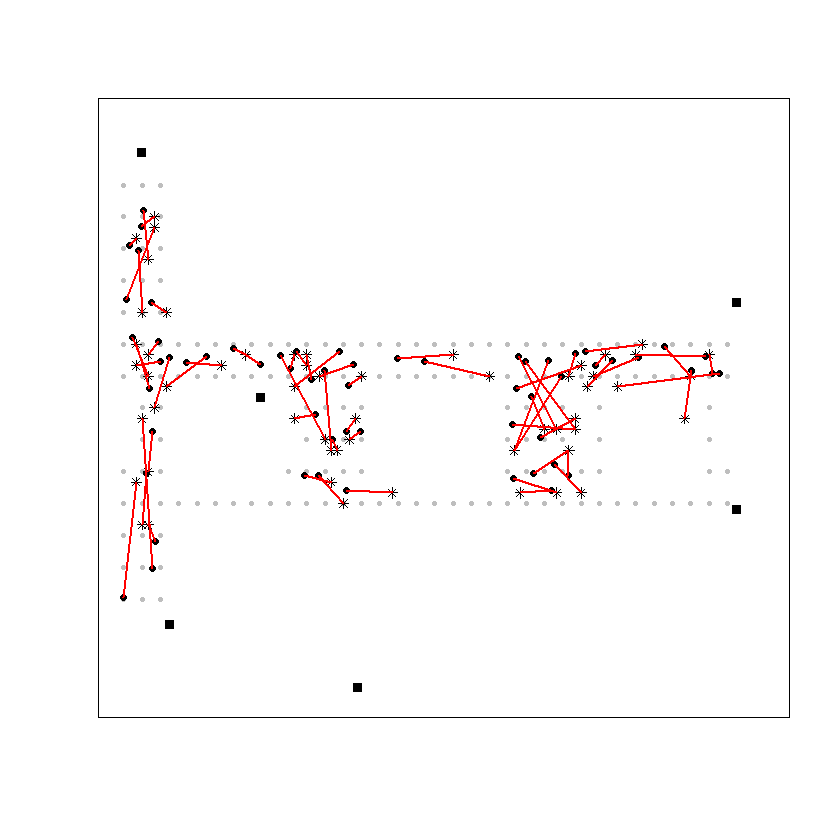

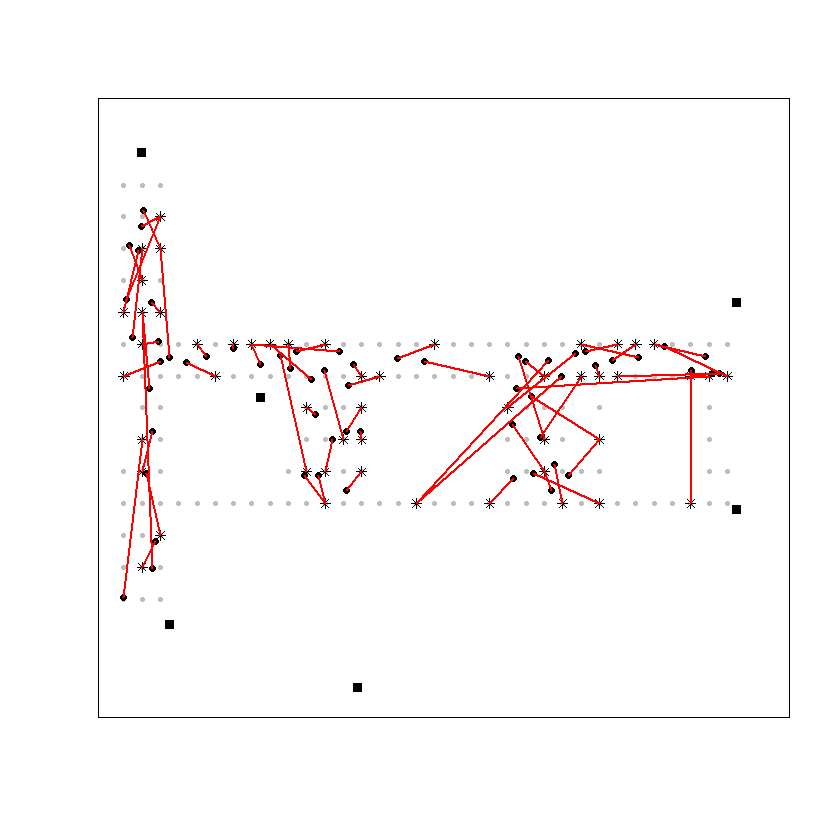

In [25]:
# predict and map errors
floorErrorMap = function(estXY, actualXY, trainPoints = NULL, AP = NULL){
  
    plot(0, 0, xlim = c(0, 35), ylim = c(-3, 15), type = "n",
         xlab = "", ylab = "", axes = FALSE)
    box()
    if ( !is.null(AP) ) points(AP, pch = 15)
    if ( !is.null(trainPoints) )
      points(trainPoints, pch = 19, col="grey", cex = 0.6)
    
    points(x = actualXY[, 1], y = actualXY[, 2], 
           pch = 19, cex = 0.8 )
    points(x = estXY[, 1], y = estXY[, 2], 
           pch = 8, cex = 0.8 )
    segments(x0 = estXY[, 1], y0 = estXY[, 2],
             x1 = actualXY[, 1], y1 = actualXY[ , 2],
             lwd = 2, col = "red")
}

trainPoints = offlineSummary[ offlineSummary$angle == 0 & 
                              offlineSummary$mac == "00:0f:a3:39:e1:c0" ,
                        c("posX", "posY")]

# 3 NN

floorErrorMap(estXYk3, onlineSummary[ , c("posX","posY")], 
              trainPoints = trainPoints, AP = AP)


# 1 NN
floorErrorMap(estXYk1, onlineSummary[ , c("posX","posY")], 
              trainPoints = trainPoints, AP = AP)

In [26]:

options(error = recover, warn = 1)
calcError = 
function(estXY, actualXY) 
   sum( rowSums( (estXY - actualXY)^2) )

actualXY = onlineSummary[ , c("posX", "posY")]
sapply(list(estXYk1, estXYk3), calcError, actualXY)
v = 11
permuteLocs = sample(unique(offlineSummary$posXY))
permuteLocs = matrix(permuteLocs, ncol = v, 
                     nrow = floor(length(permuteLocs)/v))

onlineFold = subset(offlineSummary, posXY %in% permuteLocs[ , 1])

reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY"),
                     sampleAngle = FALSE, 
                     refs = seq(0, 315, by = 45)) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    if (sampleAngle) {
                      x = x[x$angle == sample(refs, size = 1), ]}
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 6,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}





[1] 659 307

Warning message in matrix(permuteLocs, ncol = v, nrow = floor(length(permuteLocs)/v)):
"data length [166] is not a sub-multiple or multiple of the number of rows [15]"


## Model1 with MAC address "00:0f:a3:39:dd:cd" removed

[1] 171

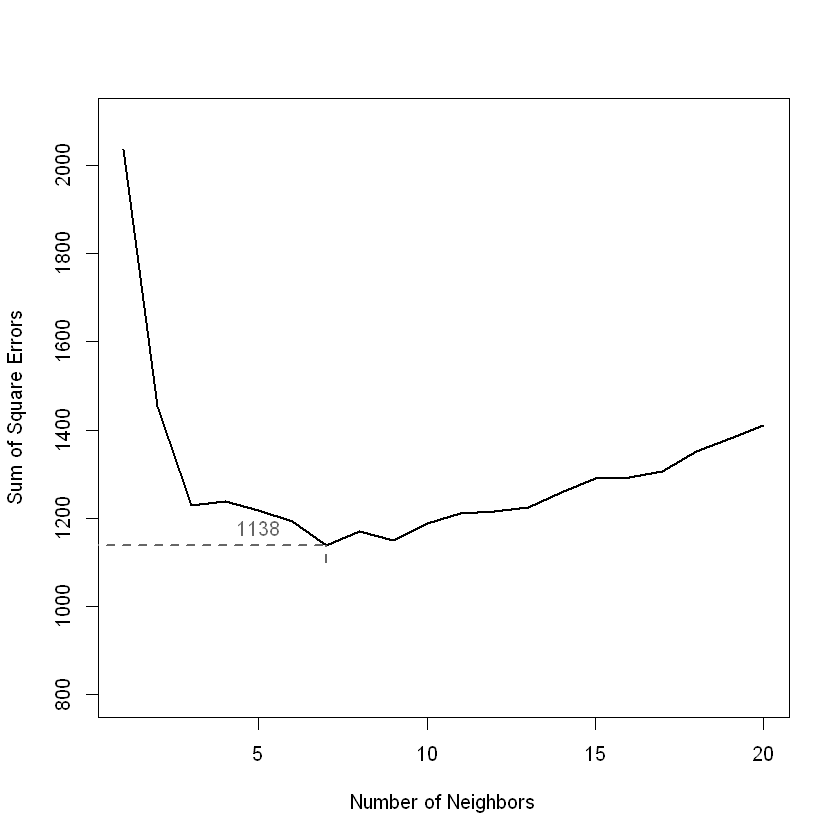

In [32]:
# train model with MAC address "00:0f:a3:39:dd:cd" removed
# up to 20 neighbors, 11 folds
# this one can run for a while (5-10 mins) -- 3 min
# this cell and the next are the same, but the angles change slightly!!
offline = offline[ offline$mac != "00:0f:a3:39:dd:cd", ]

keepVars = c("posXY", "posX","posY", "orientation", "angle")

onlineCVSummary = reshapeSS(offline, keepVars = keepVars, 
                            sampleAngle = FALSE) # set sampleAngle = FALSE  

onlineFold = subset(onlineCVSummary, 
                    posXY %in% permuteLocs[ , 1])

offlineFold = subset(offlineSummary,
                     posXY %in% permuteLocs[ , -1])

estFold = predXY(newSignals = onlineFold[ , 6:11], 
                 newAngles = onlineFold[ , 4], 
                 offlineFold, numAngles = 1, k = 3)

actualFold = onlineFold[ , c("posX", "posY")]
calcError(estFold, actualFold)

K = 20
err = rep(0, K)

for (j in 1:v) {
  onlineFold = subset(onlineCVSummary, 
                      posXY %in% permuteLocs[ , j])
  offlineFold = subset(offlineSummary,
                       posXY %in% permuteLocs[ , -j])
  actualFold = onlineFold[ , c("posX", "posY")]
  
  for (k in 1:K) {
    estFold = predXY(newSignals = onlineFold[ , 6:11],
                     newAngles = onlineFold[ , 4], 
                     offlineFold, numAngles = 1, k = k)
    err[k] = err[k] + calcError(estFold, actualFold)
  }
}


plot(y = err, x = (1:K),  type = "l", lwd= 2,
     ylim = c(800, 2100),
     xlab = "Number of Neighbors",
     ylab = "Sum of Square Errors")

rmseMin = min(err)
kMin = which(err == rmseMin)[1]
segments(x0 = 0, x1 = kMin, y0 = rmseMin, col = gray(0.4), 
         lty = 2, lwd = 2)
segments(x0 = kMin, x1 = kMin, y0 = 1100,  y1 = rmseMin, 
         col = grey(0.4), lty = 2, lwd = 2)

#mtext(kMin, side = 1, line = 1, at = kMin, col = grey(0.4))
text(x = kMin - 2, y = rmseMin + 40, 
     label = as.character(round(rmseMin)), col = grey(0.4))

In [33]:
estXYk5 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 1, k = 5)

calcError(estXYk5, actualXY)

[1] 417

In [41]:
# estXYk7 = predXY(newSignals = onlineSummary[ , 6:11], 
#                  newAngles = onlineSummary[ , 4], 
#                  offlineSummary, numAngles = 1, k = 7)

# calcError(estXYk7, actualXY)

## Model2 with MAC address "00:0f:a3:39:e1:c0" removed

In [38]:
#prepare the trainning data
# reset the training data set

offline = readData()

offline$posXY = paste(offline$posX, offline$posY, sep = "-")

byLocAngleAP = with(offline, 
                    by(offline, list(posXY, angle, mac), 
                       function(x) x))

signalSummary = 
  lapply(byLocAngleAP,            
         function(oneLoc) {
           ans = oneLoc[1, ]
           ans$medSignal = median(oneLoc$signal)
           ans$avgSignal = mean(oneLoc$signal)
           ans$num = length(oneLoc$signal)
           ans$sdSignal = sd(oneLoc$signal)
           ans$iqrSignal = IQR(oneLoc$signal)
           ans
           })

offlineSummary = do.call("rbind", signalSummary)  

subMacs = c("00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd", "00:14:bf:b1:97:8a",
                       "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d",
                       "00:14:bf:b1:97:81")
# here is where we drop a macid
offlineSummary = subset(offlineSummary, mac != subMacs[1])

In [42]:
head(offlineSummary)

time                posX posY orientation mac               signal
7      2006-02-10 23:31:58 0     0   0.0         00:0f:a3:39:dd:cd -75   
24512  2006-02-11 00:03:44 0     1   0.7         00:0f:a3:39:dd:cd -73   
221777 2006-02-11 03:46:02 0    10   0.9         00:0f:a3:39:dd:cd -69   
229191 2006-02-11 03:54:05 0    11   0.4         00:0f:a3:39:dd:cd -72   
236493 2006-02-11 04:02:32 0    12   0.2         00:0f:a3:39:dd:cd -72   
243546 2006-02-11 04:14:12 0    13   0.1         00:0f:a3:39:dd:cd -69   
       rawTime angle posXY medSignal avgSignal num sdSignal iqrSignal
7      1.1e+12 0     0-0   -67       -68       111 3.2      4.5      
24512  1.1e+12 0     0-1   -70       -70       110 2.4      3.0      
221777 1.1e+12 0     0-10  -67       -69       111 4.4      6.5      
229191 1.1e+12 0     0-11  -73       -74       111 5.4      7.0      
236493 1.1e+12 0     0-12  -70       -70       114 2.4      3.0      
243546 1.1e+12 0     0-13  -74       -74       109 3.5      4.0

In [43]:
trainSS = reshapeSS(offlineSubset, varSignal = "avgSignal")

selectTrain = function(angleNewObs, signals = NULL, m = 1){
  # m is the number of angles to keep between 1 and 5
  refs = seq(0, by = 45, length  = 8)
  nearestAngle = roundOrientation(angleNewObs)
  
  if (m %% 2 == 1) 
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  else {
    m = m + 1
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
    if (sign(angleNewObs - nearestAngle) > -1) 
      angles = angles[ -1 ]
    else 
      angles = angles[ -m ]
  }
  angles = angles + nearestAngle
  angles[angles < 0] = angles[ angles < 0 ] + 360
  angles[angles > 360] = angles[ angles > 360 ] - 360
  angles = sort(angles) 
  
  offlineSubset = signals[ signals$angle %in% angles, ]
  reshapeSS(offlineSubset, varSignal = "avgSignal")
}

train130 = selectTrain(130, offlineSummary, m = 3)

head(train130)

length(train130[[1]])

posXY posX posY 00:0f:a3:39:dd:cd 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81
0-0  0-0   0     0   -72               -66               -63              
0-1  0-1   0     1   -70               -65               -64              
0-10 0-10  0    10   -70               -66               -69              
0-11 0-11  0    11   -71               -67               -70              
0-12 0-12  0    12   -69               -70               -72              
0-13 0-13  0    13   -73               -71               -73              
     00:14:bf:b1:97:8a 00:14:bf:b1:97:8d 00:14:bf:b1:97:90
0-0  -36               -64               -55              
0-1  -39               -65               -59              
0-10 -45               -67               -50              
0-11 -48               -67               -55              
0-12 -45               -67               -50              
0-13 -43               -69               -54

[1] 166

In [44]:
# here is our NN function.
findNN = function(newSignal, trainSubset) {
  diffs = apply(trainSubset[ , 4:9], 1, 
                function(x) x - newSignal)
  dists = apply(diffs, 2, function(x) sqrt(sum(x^2)) )
  closest = order(dists)
  return(trainSubset[closest, 1:3 ])
}

In [45]:
# predict X-Y based on the the neasest k neighbors (default 3)
predXY = function(newSignals, newAngles, trainData, 
                  numAngles = 1, k = 3){
  
  closeXY = list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    closeXY[[i]] = 
      findNN(newSignal = as.numeric(newSignals[i, ]), trainSS)
  }

  estXY = lapply(closeXY, 
                 function(x) sapply(x[ , 2:3], 
                                    function(x) mean(x[1:k])))
  estXY = do.call("rbind", estXY)
  return(estXY)
}
                                    
# nearest 3 neighbors                                    
                                    
estXYk3 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 3)

# nearest neighbor
estXYk1 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 1)

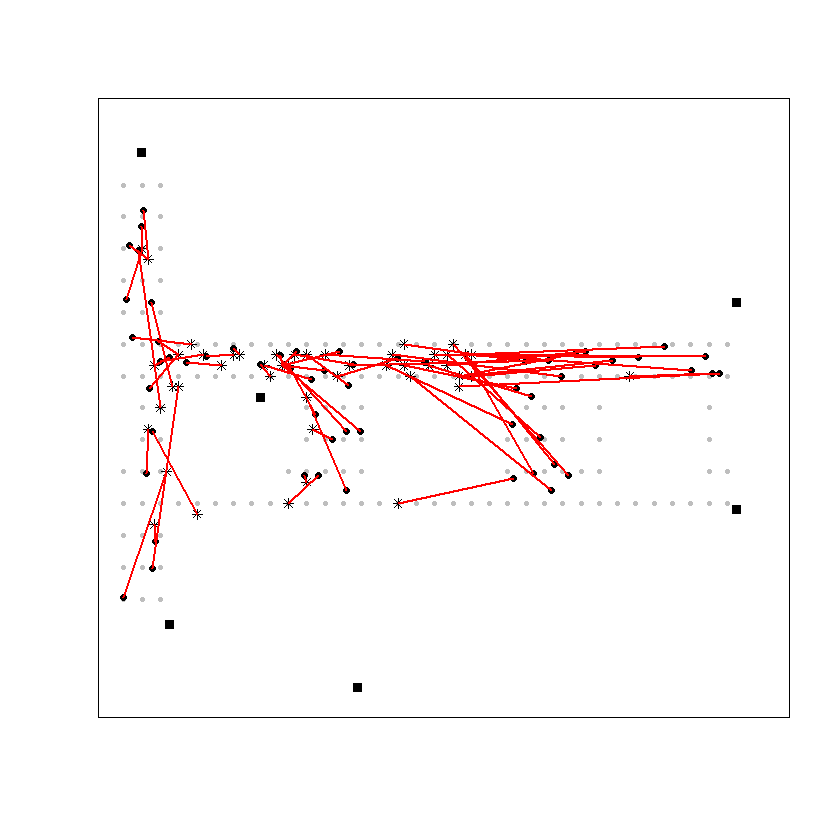

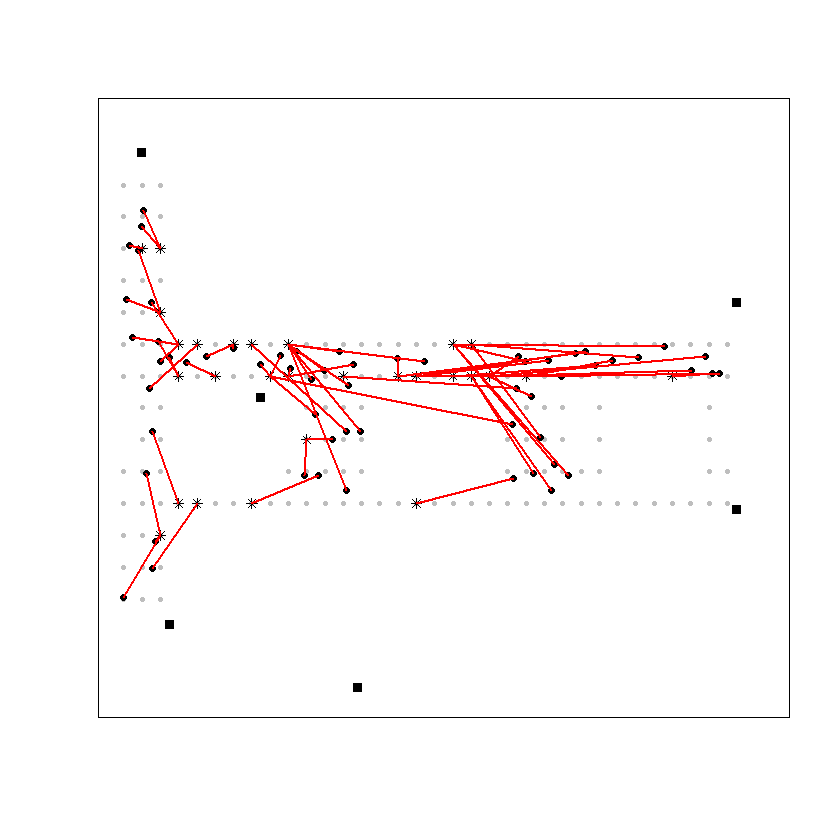

In [46]:
# predict and map errors
floorErrorMap = function(estXY, actualXY, trainPoints = NULL, AP = NULL){
  
    plot(0, 0, xlim = c(0, 35), ylim = c(-3, 15), type = "n",
         xlab = "", ylab = "", axes = FALSE)
    box()
    if ( !is.null(AP) ) points(AP, pch = 15)
    if ( !is.null(trainPoints) )
      points(trainPoints, pch = 19, col="grey", cex = 0.6)
    
    points(x = actualXY[, 1], y = actualXY[, 2], 
           pch = 19, cex = 0.8 )
    points(x = estXY[, 1], y = estXY[, 2], 
           pch = 8, cex = 0.8 )
    segments(x0 = estXY[, 1], y0 = estXY[, 2],
             x1 = actualXY[, 1], y1 = actualXY[ , 2],
             lwd = 2, col = "red")
}

trainPoints = offlineSummary[ offlineSummary$angle == 0 & 
                              offlineSummary$mac == "00:0f:a3:39:dd:cd" ,
                        c("posX", "posY")]

# 3 NN

floorErrorMap(estXYk3, onlineSummary[ , c("posX","posY")], 
              trainPoints = trainPoints, AP = AP)


# 1 NN
floorErrorMap(estXYk1, onlineSummary[ , c("posX","posY")], 
              trainPoints = trainPoints, AP = AP)

In [47]:
options(error = recover, warn = 1)
calcError = 
function(estXY, actualXY) 
   sum( rowSums( (estXY - actualXY)^2) )

actualXY = onlineSummary[ , c("posX", "posY")]
sapply(list(estXYk1, estXYk3), calcError, actualXY)
v = 11
permuteLocs = sample(unique(offlineSummary$posXY))
permuteLocs = matrix(permuteLocs, ncol = v, 
                     nrow = floor(length(permuteLocs)/v))

onlineFold = subset(offlineSummary, posXY %in% permuteLocs[ , 1])

reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY"),
                     sampleAngle = FALSE, 
                     refs = seq(0, 315, by = 45)) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    if (sampleAngle) {
                      x = x[x$angle == sample(refs, size = 1), ]}
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 6,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}


[1] 1752 1910

Warning message in matrix(permuteLocs, ncol = v, nrow = floor(length(permuteLocs)/v)):
"data length [166] is not a sub-multiple or multiple of the number of rows [15]"


[1] 126

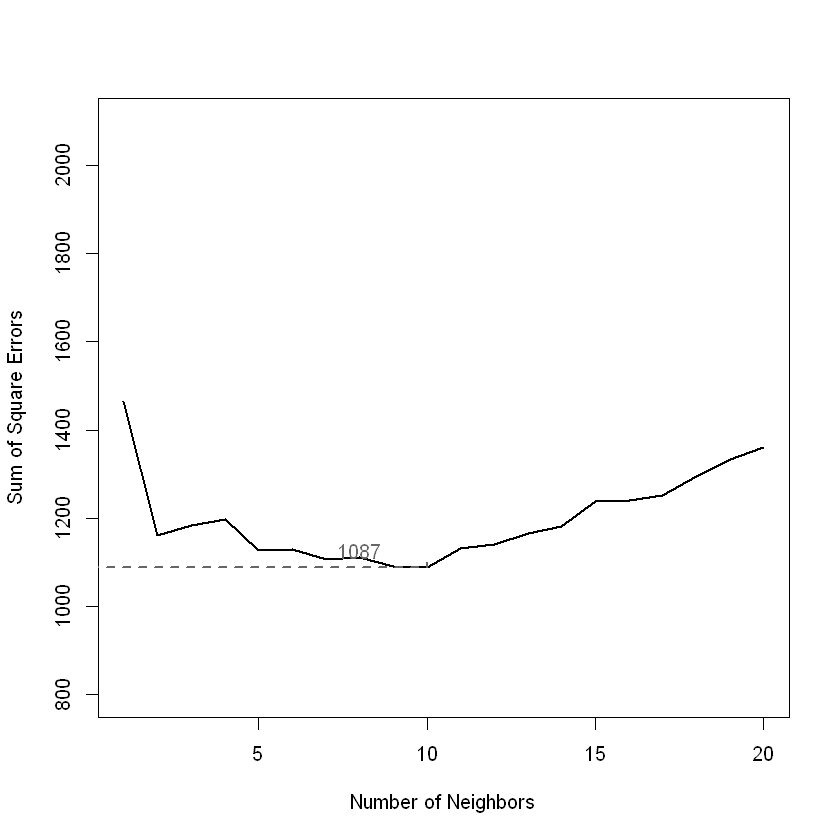

In [48]:
# train model with MAC address "00:0f:a3:39:e1:c0" removed
# up to 20 neighbors, 11 folds
# this one can run for a while (5-10 mins) -- 3 min
# this cell and the next are the same, but the angles change slightly!!
offline = offline[ offline$mac != "00:0f:a3:39:e1:c0", ]

keepVars = c("posXY", "posX","posY", "orientation", "angle")

onlineCVSummary = reshapeSS(offline, keepVars = keepVars, 
                            sampleAngle = FALSE) # set sampleAngle = FALSE  

onlineFold = subset(onlineCVSummary, 
                    posXY %in% permuteLocs[ , 1])

offlineFold = subset(offlineSummary,
                     posXY %in% permuteLocs[ , -1])

estFold = predXY(newSignals = onlineFold[ , 6:11], 
                 newAngles = onlineFold[ , 4], 
                 offlineFold, numAngles = 1, k = 3)

actualFold = onlineFold[ , c("posX", "posY")]
calcError(estFold, actualFold)

K = 20
err = rep(0, K)

for (j in 1:v) {
  onlineFold = subset(onlineCVSummary, 
                      posXY %in% permuteLocs[ , j])
  offlineFold = subset(offlineSummary,
                       posXY %in% permuteLocs[ , -j])
  actualFold = onlineFold[ , c("posX", "posY")]
  
  for (k in 1:K) {
    estFold = predXY(newSignals = onlineFold[ , 6:11],
                     newAngles = onlineFold[ , 4], 
                     offlineFold, numAngles = 1, k = k)
    err[k] = err[k] + calcError(estFold, actualFold)
  }
}


plot(y = err, x = (1:K),  type = "l", lwd= 2,
     ylim = c(800, 2100),
     xlab = "Number of Neighbors",
     ylab = "Sum of Square Errors")

rmseMin = min(err)
kMin = which(err == rmseMin)[1]
segments(x0 = 0, x1 = kMin, y0 = rmseMin, col = gray(0.4), 
         lty = 2, lwd = 2)
segments(x0 = kMin, x1 = kMin, y0 = 1100,  y1 = rmseMin, 
         col = grey(0.4), lty = 2, lwd = 2)

#mtext(kMin, side = 1, line = 1, at = kMin, col = grey(0.4))
text(x = kMin - 2, y = rmseMin + 40, 
     label = as.character(round(rmseMin)), col = grey(0.4))

In [61]:
estXYk7 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 1, k = 7)

calcError(estXYk7, actualXY)

# error k9 2136.99042345679

[1] 2151

In [56]:
crossValidation <- function(train_full, train_summary, K=20, folds=11, 
                          keepVars = c("posXY", "posX","posY", "orientation", "angle"),
                          Weighted=FALSE, distance = "euclidean") {
  set.seed(25)
  permuteLocs <- sample(unique(train_summary$posXY))
  permuteLocs <- matrix(permuteLocs, ncol = folds, 
                       nrow = floor(length(permuteLocs)/folds))
  onlineCVSummary <- reshapeSS(train_full, keepVars = keepVars, sampleAngle = TRUE)
  err = rep(0, K)
  for (j in 1:folds) {
    onlineFold <- subset(onlineCVSummary, 
                        posXY %in% permuteLocs[ , j])
    offlineFold <- subset(train_summary,
                         posXY %in% permuteLocs[ , -j])
    actualFold <- onlineFold[ , c("posX", "posY")]
    
    for (k in 1:K) {
      if(Weighted == TRUE){
        estFold <- predXYWeighted(newSignals = onlineFold[ , 6:11],
                            newAngles = onlineFold[ , 4], 
                            offlineFold, numAngles = 3, k = k)
        err[k] <- err[k] + calcError(estFold, actualFold)
        
      } else {
        if(distance == "manhattan"){
            
             estFold <- predXYManhattan(newSignals = onlineFold[ , 6:11],
                         newAngles = onlineFold[ , 4], 
                         offlineFold, numAngles = 3, k = k)
            err[k] <- err[k] + calcError(estFold, actualFold)
            
        } else {
            estFold <- predXY(newSignals = onlineFold[ , 6:11],
                             newAngles = onlineFold[ , 4], 
                             offlineFold, numAngles = 3, k = k)
            err[k] <- err[k] + calcError(estFold, actualFold)
            }
      }
    }
  }
  rmseMin <- min(err)
  kMin <- which(err == rmseMin)[1]
  return(list(rmseMin, kMin, err))
}

In [73]:
head(offlineSummary0)

time                posX posY orientation mac               signal
3      2006-02-10 23:31:58 0     0   0.0         00:0f:a3:39:e1:c0 -53   
24507  2006-02-11 00:03:44 0     1   0.7         00:0f:a3:39:e1:c0 -49   
221774 2006-02-11 03:46:02 0    10   0.9         00:0f:a3:39:e1:c0 -53   
229185 2006-02-11 03:54:05 0    11   0.4         00:0f:a3:39:e1:c0 -53   
236489 2006-02-11 04:02:32 0    12   0.2         00:0f:a3:39:e1:c0 -54   
243539 2006-02-11 04:14:12 0    13   0.1         00:0f:a3:39:e1:c0 -57   
       rawTime angle posXY medSignal avgSignal num sdSignal iqrSignal
3      1.1e+12 0     0-0   -51       -51       110 1.4      2.0      
24507  1.1e+12 0     0-1   -51       -51       110 2.2      3.0      
221774 1.1e+12 0     0-10  -56       -56       110 1.1      1.0      
229185 1.1e+12 0     0-11  -53       -55       110 3.4      7.0      
236489 1.1e+12 0     0-12  -55       -57       110 3.6      7.8      
243539 1.1e+12 0     0-13  -57       -57       110 1.4      1.0

In [68]:
offline0 = offline[ offline$mac != "00:0f:a3:39:dd:cd", ]
knnResultsModel1 <- crossValidation(offline0, offlineSummary0, K=20)

Warning message in matrix(permuteLocs, ncol = folds, nrow = floor(length(permuteLocs)/folds)):
"data length [166] is not a sub-multiple or multiple of the number of rows [15]"


In [77]:
print("Results when without MAC 00:0f:a3:39:dd:cd:")
print(paste("Mean Square Error: ",knnResultsModel1[1]," Optimal K: ",knnResultsModel1[2]))

[1] "Results when without MAC 00:0f:a3:39:dd:cd:"
[1] "Mean Square Error:  1038.5  Optimal K:  6"


In [72]:
head(offlineSummary1)

time                posX posY orientation mac               signal
7      2006-02-10 23:31:58 0     0   0.0         00:0f:a3:39:dd:cd -75   
24512  2006-02-11 00:03:44 0     1   0.7         00:0f:a3:39:dd:cd -73   
221777 2006-02-11 03:46:02 0    10   0.9         00:0f:a3:39:dd:cd -69   
229191 2006-02-11 03:54:05 0    11   0.4         00:0f:a3:39:dd:cd -72   
236493 2006-02-11 04:02:32 0    12   0.2         00:0f:a3:39:dd:cd -72   
243546 2006-02-11 04:14:12 0    13   0.1         00:0f:a3:39:dd:cd -69   
       rawTime angle posXY medSignal avgSignal num sdSignal iqrSignal
7      1.1e+12 0     0-0   -67       -68       111 3.2      4.5      
24512  1.1e+12 0     0-1   -70       -70       110 2.4      3.0      
221777 1.1e+12 0     0-10  -67       -69       111 4.4      6.5      
229191 1.1e+12 0     0-11  -73       -74       111 5.4      7.0      
236493 1.1e+12 0     0-12  -70       -70       114 2.4      3.0      
243546 1.1e+12 0     0-13  -74       -74       109 3.5      4.0

In [75]:
# head(offline1)

In [76]:
offline1 = offline[ offline$mac != "00:0f:a3:39:e1:c0", ]
knnResultsModel2 <- crossValidation(offline1, offlineSummary1, K=20)

Warning message in matrix(permuteLocs, ncol = folds, nrow = floor(length(permuteLocs)/folds)):
"data length [166] is not a sub-multiple or multiple of the number of rows [15]"


In [78]:
print("Results when without MAC 00:0f:a3:39:e1:c0:")
print(paste("Mean Square Error: ",knnResultsModel2[1]," Optimal K: ",knnResultsModel2[2]))

[1] "Results when without MAC 00:0f:a3:39:e1:c0:"
[1] "Mean Square Error:  935.611111111111  Optimal K:  6"


## Model3 with both MAC

In [79]:

# when keep both data has 7 MACs
reshapeSS <- function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY"),
                     sampleAngle = FALSE, 
                     refs = seq(0, 315, by = 45)) {
  byLocation <-
    with(data, by(data, list(posXY), 
                  function(x) {
                    if (sampleAngle) {
                      x <- x[x$angle == sample(refs, size = 1), ]}
                    ans <- x[1, keepVars]
                    avgSS <- tapply(x[ , varSignal ], x$mac, mean)
                    y <- matrix(avgSS, nrow = 1, ncol = 7,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS <- do.call("rbind", byLocation)
  return(newDataSS)
}

In [80]:
knnResultsModel3 <- crossValidation(offline, offlineSummary, K=20)

Warning message in matrix(permuteLocs, ncol = folds, nrow = floor(length(permuteLocs)/folds)):
"data length [166] is not a sub-multiple or multiple of the number of rows [15]"


In [81]:
print("Results when without MAC 00:0f:a3:39:e1:c0:")
print(paste("Mean Square Error: ",knnResultsModel3[1]," Optimal K: ",knnResultsModel3[2]))

[1] "Results when without MAC 00:0f:a3:39:e1:c0:"
[1] "Mean Square Error:  1100  Optimal K:  4"


## Models Comparison

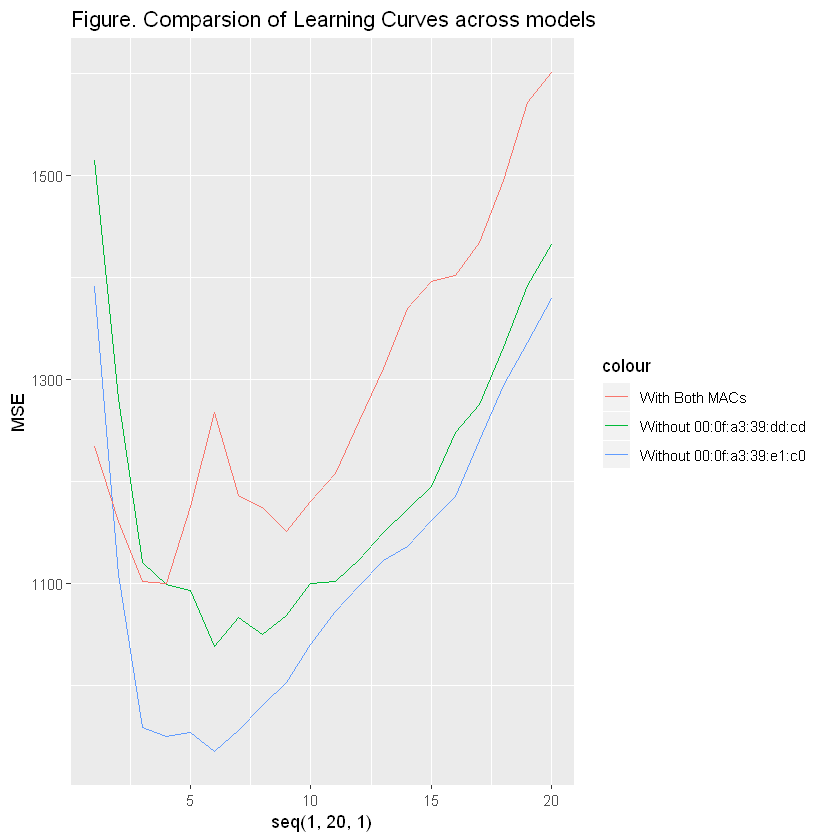

In [84]:
#plot for Model Comparison
library(ggplot2)
k = 20
ggplot()+
  geom_line(mapping=aes(x=seq(1,20,1), y=knnResultsModel1[[3]], color="Without 00:0f:a3:39:dd:cd"), show.legend = TRUE)+
  geom_line(mapping=aes(x=seq(1,20,1), y=knnResultsModel2[[3]], color="Without 00:0f:a3:39:e1:c0"), show.legend = TRUE)+
  geom_line(mapping=aes(x=seq(1,20,1), y=knnResultsModel3[[3]], color="With Both MACs"),  show.legend = TRUE)+
  ggtitle('Figure. Comparsion of Learning Curves across models')+
  labs(y="MSE")

### Results
#### From the plot above, we can see Model2 Without 00:0f:a3:39:e1:c0 yielded the lowest MSE.  (may need to zoom in the fig)
#### Model3 both MAC addresses simultaneously yield less, accurate prediction of location.

## Weighted kNN for the best model above

In [85]:
# function to calculate the distance from the test data to all of the training data and get the top 3 nearest.
findNNWeighted <- function(newSignal, trainSubset) {
  diffs <- apply(trainSubset[ , 4:9], 1, 
                function(x) x - newSignal)
  dists <- apply(diffs, 2, function(x) sqrt(sum(x^2)) )
  closest <- order(dists)
  weight <- as.numeric(1/dists[closest])
  closeXY <- trainSubset[closest, 1:3 ]
  return(cbind(closeXY,weight))
}
                 

In [86]:

# function to get the estimate location 
predXYWeighted <- function(newSignals, newAngles, trainData, 
                  numAngles = 1, k = 3){
  
  closeXY <- list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS <- selectTrain(newAngles[i], trainData, m = numAngles)
    base <- findNNWeighted(newSignal = as.numeric(newSignals[i, ]), trainSS)
    weights <- append(base[1:k, 4]/sum(base[1:k, 4]), rep(0, nrow(base)-k)) 
    base[, 2:3] = base[, 2:3]*weights # multiply weights array * matrix of x,y to get weighted vals
    closeXY[[i]] = base[,1:3] # append weighted xy, x, y values to list
  }

  estXY <- lapply(closeXY, 
                 function(x) sapply(x[ , 2:3], 
                                    function(x) sum(x)))
  estXY <- do.call("rbind", estXY)
  return(estXY)
}

In [87]:
knnResultsWeighted=crossValidation(offline1, offlineSummary1, K=20)

Warning message in matrix(permuteLocs, ncol = folds, nrow = floor(length(permuteLocs)/folds)):
"data length [166] is not a sub-multiple or multiple of the number of rows [15]"
Warning message in matrix(avgSS, nrow = 1, ncol = 7, dimnames = list(ans$posXY, :
"data length [6] is not a sub-multiple or multiple of the number of columns [7]"


ERROR: Error in matrix(avgSS, nrow = 1, ncol = 7, dimnames = list(ans$posXY, : length of 'dimnames' [2] not equal to array extent


In [ ]:

k = 20
ggplot()+
  geom_line(mapping=aes(x=seq(1,20,1), y=knnResultsModel1[[3]], color="Without 00:0f:a3:39:dd:cd"), linetype="solid", show.legend = TRUE)+
  geom_line(mapping=aes(x=seq(1,20,1), y=knnResultsModel2[[3]], color="Without 00:0f:a3:39:e1:c0"), linetype="dashed", show.legend = TRUE)+
  geom_line(mapping=aes(x=seq(1,20,1), y=knnResultsModel3[[3]], color="With Both MACs"), linetype="dotted", show.legend = TRUE)+
  #geom_line(mapping=aes(x=seq(1,20,1), y=knnResultsManhattan[[3]], color="KNN using Manhattan Distance"), linetype="dotdash", show.legend = TRUE)+
  geom_line(mapping=aes(x=seq(1,20,1), y=knnResultsWeighted[[3]], color="MSE of Weighted KNN"), linetype="longdash", show.legend = TRUE)+
  ggtitle('Figure. Comparsion of Learning Curves across models')+
  labs(y="MSE")